In [3]:
import pandas as pd

original_df = pd.read_csv("data/monthly-australian-wine-sales.csv")
original_df.head()

,month,sales
0,1980-01-01,15136
1,1980-02-01,16733
2,1980-03-01,20016
3,1980-04-01,17708
4,1980-05-01,18019


In [4]:
original_df["timestamp"] = pd.to_datetime(original_df["month"])
original_df["target"] = original_df["sales"]
original_df.drop(columns=["month", "sales"], inplace=True)
original_df["segment"] = "main"
original_df.head()

,timestamp,target,segment
0,1980-01-01,15136,main
1,1980-02-01,16733,main
2,1980-03-01,20016,main
3,1980-04-01,17708,main
4,1980-05-01,18019,main


In [5]:
import warnings

warnings.filterwarnings(action="ignore", message="Torchmetrics v0.9")
from etna.datasets.tsdataset import TSDataset

In [6]:
df = TSDataset.to_dataset(original_df)
df.head()

segment,main
feature,target
timestamp,
1980-01-01,15136
1980-02-01,16733
1980-03-01,20016
1980-04-01,17708
1980-05-01,18019


In [7]:
ts = TSDataset(df, freq="MS")

In [8]:
ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 1
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: MS
         start_timestamp end_timestamp  length  num_missing
segments                                                   
main          1980-01-01    1994-08-01     176            0


In [9]:
ts.describe()

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
main,1980-01-01,1994-08-01,176,0,1,0,0,0,MS


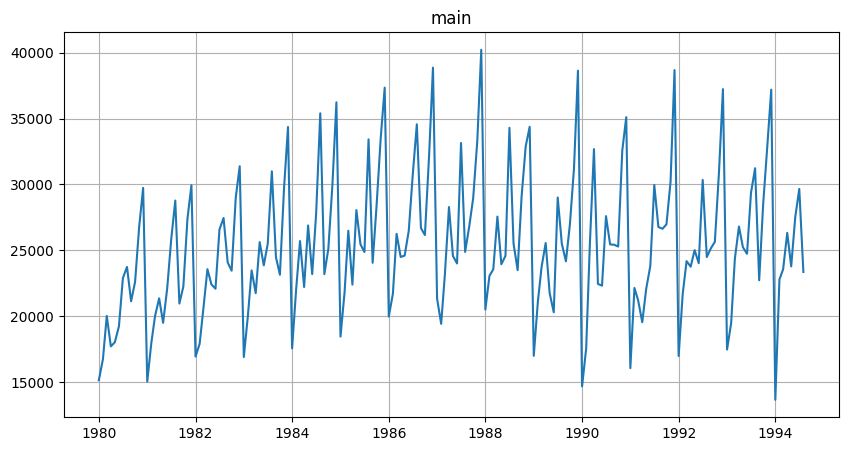

In [10]:
ts.plot()

In [11]:
HORIZON = 8
train_ts, test_ts = ts.train_test_split(
    train_start="1980-01-01",
    train_end="1993-12-01",
    test_start="1994-01-01",
    test_end="1994-08-01",
)

In [12]:
from etna.transforms import LagTransform, LogTransform

lags = LagTransform(in_column="target", lags=list(range(8, 24, 1)))
log = LogTransform(in_column="target")
transforms = [log, lags]
train_ts.fit_transform(transforms)

In [13]:
from etna.models import CatBoostMultiSegmentModel

model = CatBoostMultiSegmentModel()
model.fit(train_ts)
future_ts = train_ts.make_future(future_steps=HORIZON, transforms=transforms)
forecast_ts = model.forecast(future_ts)
forecast_ts.inverse_transform(transforms)

/home/aleksandr/PycharmProjects/Aramco_Inn_test/venv/lib/python3.10/site-packages/etna/datasets/tsdataset.py:277: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(


In [14]:
from etna.metrics import SMAPE

smape = SMAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

{'main': 10.657026308972481}

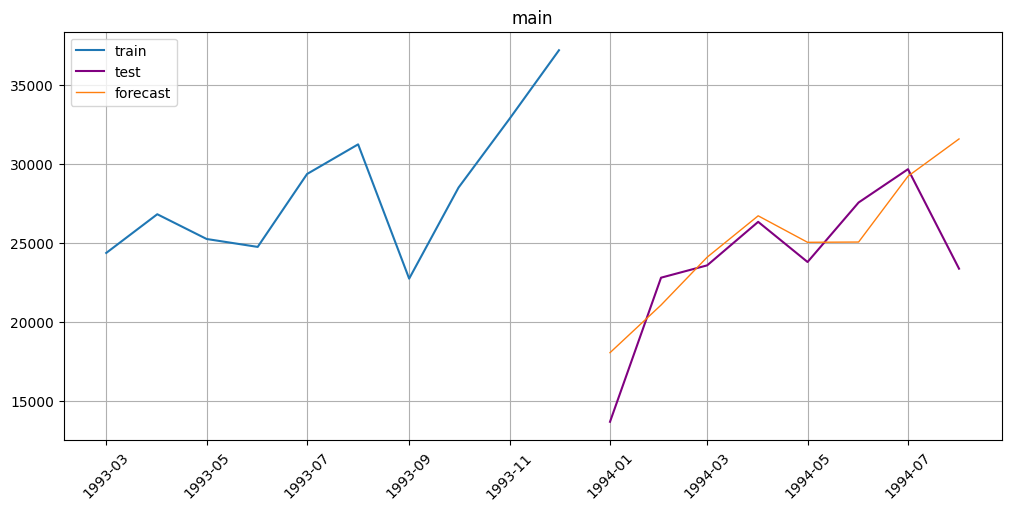

In [15]:
from etna.analysis import plot_forecast

train_ts.inverse_transform(transforms)
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10)

In [16]:
# using Pipeline
from etna.pipeline import Pipeline

In [17]:
HORIZON = 8
train_ts, test_ts = ts.train_test_split(
    train_start="1980-01-01",
    train_end="1993-12-01",
    test_start="1994-01-01",
    test_end="1994-08-01",
)

In [18]:
model = Pipeline(
    model=CatBoostMultiSegmentModel(),
    transforms=transforms,
    horizon=HORIZON,
)
model.fit(train_ts)
forecast_ts = model.forecast()

/home/aleksandr/PycharmProjects/Aramco_Inn_test/venv/lib/python3.10/site-packages/etna/datasets/tsdataset.py:277: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(


In [19]:
smape = SMAPE()
smape(y_true=test_ts, y_pred=forecast_ts)

{'main': 10.657026308972481}

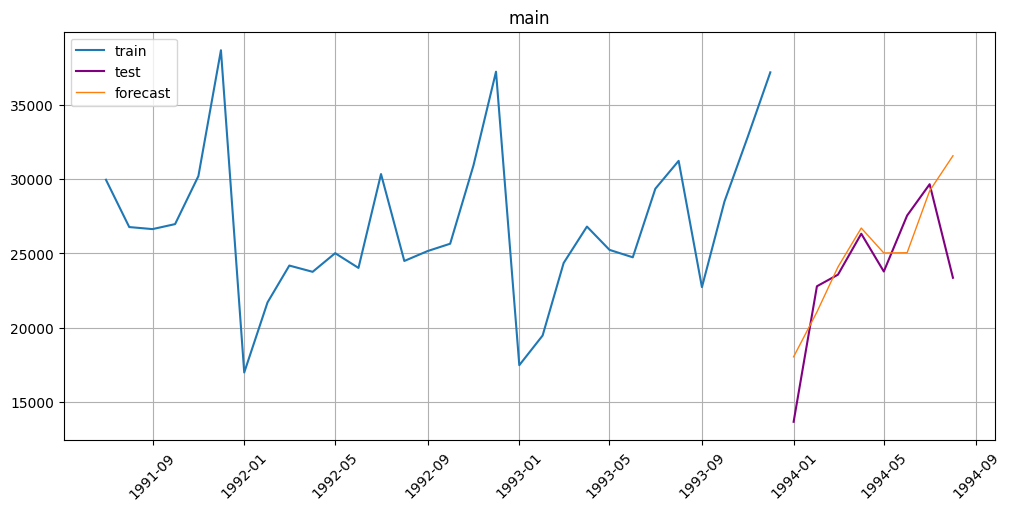

In [20]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=30)

In [32]:
forecast_ts.df['main']['target']

timestamp
1994-01-01    18032.064072
1994-02-01    21050.588682
1994-03-01    24082.059321
1994-04-01    26705.300880
1994-05-01    25026.375415
1994-06-01    25043.113654
1994-07-01    29213.861961
1994-08-01    31576.674221
Freq: MS, Name: target, dtype: float64

In [42]:
test_ts.df['main']['target']

timestamp
1994-01-01    13652
1994-02-01    22784
1994-03-01    23565
1994-04-01    26323
1994-05-01    23779
1994-06-01    27549
1994-07-01    29660
1994-08-01    23356
Freq: MS, Name: target, dtype: int64

In [70]:
d1 = pd.DataFrame({
    'forecast': map(int, forecast_ts.df['main']['target'].array),
    'test': test_ts.df['main']['target'].array
})
d2 = pd.DataFrame({'train': map(int, train_ts.df['main']['target'].array)})

d = d1.merge(d2, how='cross')
d

,forecast,test,train
0,18032,13652,15135
1,18032,13652,16733
2,18032,13652,20016
3,18032,13652,17708
4,18032,13652,18018
...,...,...,...
1339,31576,23356,31234
1340,31576,23356,22724
1341,31576,23356,28496
1342,31576,23356,32857


In [74]:
d1 = pd.DataFrame({
    'forecast': map(int, forecast_ts.df['main']['target']),
    'test': test_ts.df['main']['target']
})
d1

,forecast,test
timestamp,,
1994-01-01,18032,13652
1994-02-01,21050,22784
1994-03-01,24082,23565
1994-04-01,26705,26323
1994-05-01,25026,23779
1994-06-01,25043,27549
1994-07-01,29213,29660
1994-08-01,31576,23356


In [77]:
d2 = pd.DataFrame({'train': train_ts.df['main']['target']})
d2

,train
timestamp,
1980-01-01,15136.0
1980-02-01,16733.0
1980-03-01,20016.0
1980-04-01,17708.0
1980-05-01,18019.0
...,...
1993-08-01,31234.0
1993-09-01,22724.0
1993-10-01,28496.0


In [81]:
d = d1.merge(d2, on='timestamp', how='outer')
d

,forecast,test,train
timestamp,,,
1994-01-01,18032.0,13652.0,NaN
1994-02-01,21050.0,22784.0,NaN
1994-03-01,24082.0,23565.0,NaN
1994-04-01,26705.0,26323.0,NaN
1994-05-01,25026.0,23779.0,NaN
...,...,...,...
1993-08-01,NaN,NaN,31234.0
1993-09-01,NaN,NaN,22724.0
1993-10-01,NaN,NaN,28496.0
